# L4d: K-Nearest Neighbor (KNN) Classification
In this lab, we'll use the kernelized variant of [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify randomly overlayed datasets. In particular, we'll take advantage of the kernel trick to project our two-dimensional dataset and our random data into a higher dimensional space where it _may_ be linearly separable.

### Backstory: The Kernel Trick
The kernel trick is a clever technique in machine learning that allows algorithms to operate in high-dimensional feature spaces without explicitly computing the coordinates in that space. It enables linear classifiers to solve nonlinear problems by implicitly mapping data into a higher-dimensional space, making complex pattern analysis more computationally efficient.

* __Mapping to higher dimensions__? We can take a feature vector $\mathbf{x}\in\mathbb{R}^{n}$ and combine its elements to make a higher dimensional object with $m$ components ($m>n$) using a feature map. For example, suppose we wanted to go from a scalar to a four-dimensional object. In this case, we could propose a feature map $\phi:\mathbb{R}\to\mathbb{R}^{4}$, such that $\phi(x) = \left(1,x,x^{2}, x^{3}\right)^{\top}$. In the language of models, this is still a linear model because we can write something like: $y = \phi\left(x\right)^{\top}\theta$, where $\theta\in\mathbb{R}^{4}$ is an (unknown) parameter vector.
* __Another meaning of kernel functions__: We know that the inner product $k(\mathbf{x},\mathbf{z}) = \left<\mathbf{x},\mathbf{z}\right>$ is a valid kernel function. However, the function $k(\mathbf{x},\mathbf{z}) = \left<\phi(\mathbf{x}),\phi(\mathbf{z})\right>$ is also a kernel function, i.e., we have applied some feature map $\phi: \mathbb{R}^{\star}\to\mathbb{R}^{\dagger}$ where $\dagger>\star$ to our input feature vectors and taken the inner product of the $\dagger$-dimensional objects. Ok, but what is the feature map $\phi$? How do I choose this? Perhaps if you have some insight, you could choose $\phi$. 
* __TLDR: You don't choose a feature mapping $\phi$__! By choosing a (valid) functional form for the kernel $k$, you are indirectly (implicitly) assuming a feature map $\phi$. Thus, in a problem, when you iterate over functional forms for the $k$ function, each function gives a new _implicit_ feature mapping. Everything else stays the same.

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: Let's take 10 minutes to explore how we will generate the datasets we'll explore today. We'll work through how to generate linearly separable and non-linearly separable datasets.
* __Task 2: Build and Train Perceptron Classification Model (20 min)__: In this task, we'll build and train a Perceptron classification model, use the trained model to estimate the labels on unseen test data, and then compute the confusion matrix.
* __Task 3:  Build and Train Logistic Regression Classification Model (20 min)?__: In this task, we'll build and train a Logistic regression classification model, use the trained model to estimate the labels on unseen test data, and then compute the confusion matrix.

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

Next, let's set some constants we'll need for the data generation logic below. Please look at the comment next to the constant for a description of what it is, permissible values, etc.

In [5]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a generated label; see below.
c̄₁ = (0.0, 0.0); # center for the cloud: fixed
θ = 60*(π/180); # rotation angle (radians)

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

### Data
We'll use [K-nearest neighbor classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify datasets, including [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset (which may or may not be linearly separable), then split it into (random) `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start by generating the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$ and will be stored in the `D::Array{Float64,2}` variable:

In [9]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=1, r₁ = 0.0, r₂ = 1.0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=-1, r₁ = 0.5, r₂ = 2.0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end

    # Finally, let's rotate the data a bit (counter-clockwise)
    R = [
        cos(θ) -sin(θ) ;
        sin(θ) cos(θ) ;
    ];

    # keep the label, but apply the rotation the (x,y) data
    D̂ = copy(D);
    for i ∈ 1:total_number_of_points
        x̂ = R*D[i,1:2];
        D̂[i,1] = x̂[1];
        D̂[i,2] = x̂[2];
    end
    
    D̂ # return the data
end;

#### Visualize dataset `D`
`Unhide` the code block below to see how we plotted the dataset `D` which contains two continuous features and a label. The color indicates the label.
* __Summary__: We will get a different pattern of $\pm{1}$ labels depending on the labeling function logic $L(x_{1},x_{2})$ we used. The dark blue dots represent label `1`, while the orange data represents label `1`. Our 
classifier should be able to learn the mapping between the features and the labels for linearly separable datasets.

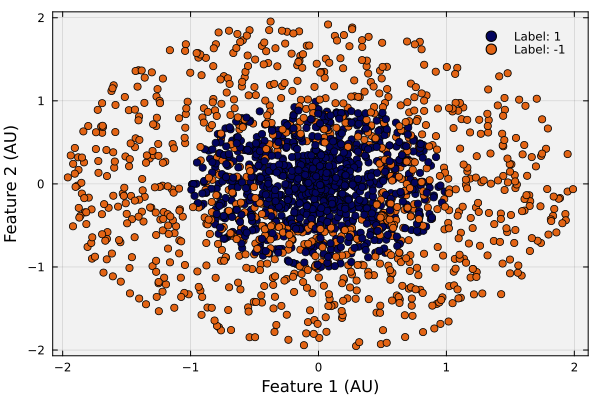

In [11]:
let

    dataset = D; # what dataset am I looking at?
    number_of_points_to_plot = size(dataset,1);
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot

    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot all points
    for i ∈ 1:number_of_points_to_plot
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

Next, let's split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [13]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

## Task 2: K-Nearest Neighbor Classification
K-nearest neighbor (KNN) classification is a simple yet powerful machine learning algorithm for classification and regression tasks. The algorithm finds the K closest data points to a new instance in the feature space and then classifies the new instance based on the majority class among these neighbors.

* __Key assumption__: The key assumption of a [K-nearest neighbor classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is that _similar_ inputs have _similar_ labels (in classification tasks) or _similar_ outputs for K-nearest neighbor regression tasks. However, the wiggly aspect of this assumption is what we mean by _similar_.

__Algorithm__
* __Initialization__. You provide some _reference_ dataset $\mathcal{D} = \{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\}$, where the vectors $\mathbf{x}_i \in \mathbb{R}^{m}$ are $m$-dimensional feature vectors ($m\ll{n}$) and the target variables are discrete labels $y_i \in \left\{-1,1\right\}$. We'll use the reference dataset $\mathcal{D}$ to compare our unknown points.
* __Inference__: The distance (similarity) between a test feature vector $\mathbf{z}$ and _all reference instances_ is computed; call this set $\mathcal{S}$. Set $\mathcal{S}$ is sorted from highest to lowest similarity. Then, a particular label is estimated from the labels of the top-K elements of the sorted neighbor set —- _decision rule_: Majority wins (but we could imagine other scenarios).

We are going to try various kernel functions to see if the implicit transformation that they encode will allow the pulling apart of the overlapping dataset.

### Similarity: Build a Kernel Function
In the code cell below, build a kernel function $k:\mathbb{R}^{2}\times\mathbb{R}^{2}\to\mathbb{R}$. You can use a [kernel exported by the `KernelFunctions.jl` package](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/), or make one up on your own. Save this function in the `k(x,y)::Function` variable:

In [16]:
k(x,y) = cos(-0.5*norm(x-y)^2)

k (generic function with 1 method)

#### Check: Is $k$ a valid Kernel function?
A function $k:\mathbb{R}^{m}\times\mathbb{R}^{m}\to\mathbb{R}$ is a _valid kernel function_ if and only if the kernel matrix $\mathbf{K}\in\mathbb{R}^{n\times{n}}$ is positive (semi)definite for all possible choices of the data vectors $\mathbf{v}_i$, where $K_{ij} = k(\mathbf{v}_i, \mathbf{v}_j)$. If $\mathbf{K}$ is positive (semi)definite, for any real-valued vector $\mathbf{x}$, the Kernel matrix $\mathbf{K}$ must satisfy $\mathbf{x}^{\top}\mathbf{K}\mathbf{x} \geq 0$. 

In [18]:
K = let

    D₂ = test;
    number_of_test_examples = size(D₂,1);
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    K = zeros(number_of_test_examples,number_of_test_examples);

    for i ∈ 1:number_of_test_examples
        vᵢ = X₂[i,:];
        for j ∈ 1:number_of_test_examples
            vⱼ = X₂[j,:];
            K[i,j] = k(vᵢ,vⱼ) # compute inner product squared
        end
    end
    K
end;

__Check__: Is $k(\mathbf{x}_{i},\mathbf{x}_{j})$ a valid kernel? For this kernel to be valid, the kernel matrix $\mathbf{K}$ needs to be positive (semi)definite. Let's check the condition: $\mathbf{x}^{\top}\,\mathbf{K}\,\mathbf{x}\geq{0}$:

In [20]:
let
    number_of_rows = size(K,1);
    x = randn(number_of_rows);
    @assert transpose(x)*K*x ≥ 0
end

### Inference

Now that we have defined a kernel function, let's use it to classify our data. We've implemented a KNN classifier in this repo. In the code block below, we:
* Construct [a `MyKNNClassificationModel` model](src/Types.jl) using a [custom `build(...)` method](src/Factory.jl). The `model` instance holds all the data for the problem, i.e., the how many neighbours to look at `K`, and the similarity function $d$.
* Next, we pass this `model` instance to [the `classify(...)` method](src/Compute.jl) which takes a test feature $\mathbf{z}$, the reference feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$, and the classifier `model` instance and returns the predicted label value $\hat{y}$ for the test feature vector $\mathbf{z}$.
* We return the predicted label in the `ŷ_KNN::Array{Int64,1}` array, and the actual label in the `y_KNN::Array{Int64,1}` array.

In [22]:
ŷ_KNN,y_KNN = let

    # Data -
    D₁ = training; # reference dataset 
    D₂ = test; # test
    number_of_training_examples = size(training,1);
    number_of_test_examples = size(test,1);
    X₁ = D₁[:,1:end-1]; # data for training (notice no extra 1)
    y₁ = D₁[:,end]; # label for training
    X₂ = D₂[:,1:end-1]; # data for test (notice no extra 1)
    y₂ = D₂[:,end]; # label for test
    ŷ₂ = zeros(number_of_test_examples);  # initialize some storage for the predicted label

    # build a model -
    model = build(MyKNNClassificationModel, (
        K = 101, # we look at this many points
        features = X₁,
        labels = y₁,
        d = (x,y) -> k(x,y), # some distance or similarity metric (replace with (x,y) -> k(x,y) for a kernel)
    ));

    # process each vector in the test set, and compare that to training (reference)
    for i ∈ 1:number_of_test_examples
        z = X₂[i,:]; # get feature vector for test
        ŷ₂[i] = classify(z,model) # classify the test vector using the training data
    end
 
    # return -
    ŷ₂,y₂
end;

### Performance 

We can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset and measure wins (when the label is the same) and losses (label is different). This is easily represented in [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
* We compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_KNN::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [24]:
CM_KNN = confusion(y_KNN,ŷ_KNN)

2×2 Matrix{Int64}:
 387   17
 130  266

Finally, we can compute the overall error rate for the perceptron (or other performance metrics) using values from [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [26]:
number_of_test_points = length(y_KNN);
correct_prediction_perceptron = CM_KNN[1,1] + CM_KNN[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.81625 Fraction incorrect 0.18374999999999997


### Visualize the misses
Using the `test` dataset, let's show (with white circles) which samples our classifier cannot predict the label correctly, i.e., where we miss the label. `Unhide` the code block below to see how we plotted the misclassified data points from the `test` dataset.
* __Summary__: When there is a clear boundary, the [KNN classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) misses along the borders between classes (even for non-linearly separable data). However, when the data is randomly arranged, the [KNN classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) cannot correctly assign the label.

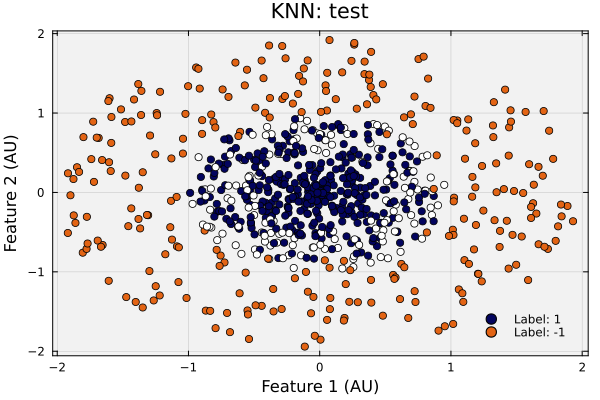

In [28]:
let

    dataset = test; # what dataset am I looking at?
    caselabel = "test";
    actual = y_KNN;
    predicted = ŷ_KNN;
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  dataset[:,3])
    c = my_color_dictionary[testlabel]
    scatter!([dataset[i,1]], [dataset[i,2]], label="Label: $(testlabel)", c=c)

    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        testlabel = predicted[i]; # predited label

        c = :white;
        if (actuallabel == testlabel)
            c = my_color_dictionary[actuallabel]
        end
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end

    title!("KNN: $(caselabel)", fontsize=18)
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end